# The  BAxUS algorithm in simple steps
>BOTorch of BAxUSes Tutorial: https://botorch.org/tutorials/baxus

A baxus algorithm that will implement Bayesian optimization with adaptively expanding subspaces(BAxUS) and find a sufficient subspace de.

## Objective function

We optimize the Branin2 function.

<img src="braninsc2.png">


Since the BoTorch assumes the maximization of the problem, the algorithm will look for the maximization of -f(x) and compares the results of Expected Improvement (EI) and Thompson Sampling(TS).

In [1]:
from botorch.test_functions import Branin
!pip install botorch

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import math
import os
from dataclasses import dataclass

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

Running on cpu


## Function using Dummy variables
Here only the first two input dimensions are passed into the actual Branin function.

In [3]:
from botorch.test_functions import Branin

branin = Branin(negate=True).to(device=device, dtype=dtype)


def branin_emb(x):
    """x is assumed to be in [-1, 1]^D"""
    lb, ub = branin.bounds
    return branin(lb + (ub - lb) * (x[..., :2] + 1) / 2)

In [4]:
fun = branin_emb
dim = 500 if not SMOKE_TEST else 50

n_init = 10 if not SMOKE_TEST else 4
max_cholesky_size = float("inf")

## Function formulas

**1. n_splits**:

<img src="n_split.png">

**2. \_\_post_init\_\_()**:

$i$ : (1 + np.arange(self.new_bins_on_split))

$d_{init}$ : self.self.d_init

$b$ : self.new_bins_on_split

$D$ : dim

<img src="dinit.png">

**3. split_budget():**

$b$ : self.new_bins_on_split

$m_{D}$ : self.eval_budget

$d_{i}$ : self.target_dim

$n$ : self.n_splits

<img src="splitbudget.png">

4. The failure tolerance depends on the target dimensionality

 **failure_tolerance():**

 $m_{i}^{s}$ : self.split_budget

<img src="tfail.png">

In [5]:
@dataclass
class BaxusState:
    # dimensionality of input variables
    dim: int 
    # evaluatoin budget
    eval_budget: int 
    # new bins each dimension split
    new_bins_on_split: int = 3  
    # initial dimensionality used by the algorithm
    d_init: int = float("nan")  
    # target dimensionality
    target_dim: int = float("nan")  
    # number of times that has been split
    n_splits: int = float("nan") 

    # trust region
    length: float = 0.8
    length_init: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    
    failure_counter: int = 0
    success_counter: int = 0

    success_tolerance: int = 3
    
    # value of new best
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        n_splits = round(math.log(self.dim, self.new_bins_on_split + 1))
        
        # 1.Set the initial dimensionality d_init
        ##### Enter your code here:

        self.d_init = 1 + np.argmin(
            np.abs(
                (1 + np.arange(self.new_bins_on_split))
                * (1 + self.new_bins_on_split) ** n_splits
                - self.dim
            )
        )
        
        ##### End of code
        
        self.target_dim = self.d_init
        self.n_splits = n_splits

    @property
    def split_budget(self) -> int:

        # 2. Calculate the split budget
        ##### Enter your code here:

        split_budget = round(
            -1
            * (self.new_bins_on_split * self.eval_budget * self.target_dim)
            / (self.d_init * (1 - (self.new_bins_on_split + 1) ** (self.n_splits + 1)))
        )
        return split_budget
        
        ##### End of code

    @property
    def failure_tolerance(self) -> int:
        if self.target_dim == self.dim:
            return self.target_dim
        k = math.floor(math.log(self.length_min / self.length_init, 0.5))
        split_budget = self.split_budget
        
        # 3.Calculate the failure tolerance:
        ##### Enter your code here:
        
        failure_tolerance = min(self.target_dim, max(1, math.floor(split_budget / k)))
        
        ##### End of code
        
        return failure_tolerance

def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region by half
        
        # 4. Halve the length of the Trust Region
        ##### Enter your code here:
        
        state.length /= 2.0

        ##### End of code
        
        state.failure_counter = 0
        
        # Question: Why do we halve it?
        # Answer: when the time of failing reaches the failure_tolerance 
        # the length of trust region will shrink to half
        

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state    

## BAxUS state

A state of BAxUS needs to be maintained, which means to maintain the state with the length of the Trust Region(TR), the success and failure tolerance($\tau_{succses}$, $\tau_{fail}$).

It is assumed that the domain has been scaled to $[-1, 1]^d$

In [6]:
state = BaxusState(dim=dim, eval_budget=500)
print(state)

BaxusState(dim=500, eval_budget=500, new_bins_on_split=3, d_init=2, target_dim=2, n_splits=4, length=0.8, length_init=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, success_counter=0, success_tolerance=3, best_value=-inf, restart_triggered=False)


<img src="algorithm1.png">

## Creating the BAxUS  Embedding

<img src='embedding matrix.png'>

* each column in S has exactly one non-zero entry

1. create a random permutation of the input dimensions 1, . . . , D.

2. The list of input dimensions is split into min(d, D) individual bins.

3. 1) If d can be divided by D, all bins can have the same size.

   2) the i-th bin has size ⌊D/d⌋ if  i + d⌊D/d⌋ ≤ D, otherwise ⌈D/d⌉.
                                                      
4. randomly assign a sign($\pm1$) to each input dimension


In [7]:
def embedding_matrix(input_dim: int, target_dim: int) -> torch.Tensor:
    if (
        target_dim >= input_dim
    ):  # return identity matrix if target size greater than input size
        return torch.eye(input_dim, device=device, dtype=dtype)

    input_dims_perm = (
        torch.randperm(input_dim, device=device) + 1
    )  # add 1 to indices for padding column in matrix

    bins = torch.tensor_split(
        input_dims_perm, target_dim
    )  # split dims into almost equally-sized bins
    bins = torch.nn.utils.rnn.pad_sequence(
        bins, batch_first=True
    )  # zero pad bins, the index 0 will be cut off later

    mtrx = torch.zeros(

        # 5. Input the shape of the embedding matrix
        ##### Enter your code here:

        (target_dim, input_dim + 1), dtype=dtype, device=device

        ##### End of code
    )  # add one extra column for padding
    mtrx = mtrx.scatter_(
        1,
        bins,
        2 * torch.randint(2, (target_dim, input_dim), dtype=dtype, device=device) - 1,
    )  # fill mask with random +/- 1 at indices

    return mtrx[:, 1:]  # cut off index zero as this corresponds to zero padding


embedding_matrix(10, 3)  # example for an embedding matrix

tensor([[ 0.,  0.,  0.,  0., -1.,  1., -1., -1.,  0.,  0.],
        [ 0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [-1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.]],
       dtype=torch.float64)

## Increase the embedding 

<img src='algorithm2.png'>

 The algorithm below follows Algorithm 2 on the slides.

 Algorithm 2 loops over the target dimensions 1, . . . , d. 
 
 For each target dimension, the contributing input dimensions are randomly re-assigned to new bins of given sizes and the observations are preserved to the increased target space.  

In [8]:
def increase_embedding_and_observations(
    S: torch.Tensor, X: torch.Tensor, n_new_bins: int
) -> torch.Tensor:
    assert X.size(1) == S.size(0), "Observations don't lie in row space of S"

    S_update = S.clone()
    X_update = X.clone()

    for row_idx in range(len(S)):
        row = S[row_idx]
        idxs_non_zero = torch.nonzero(row)
        idxs_non_zero = idxs_non_zero[torch.randperm(len(idxs_non_zero))].reshape(-1)

        if len(idxs_non_zero) <= 1:
            continue

        non_zero_elements = row[idxs_non_zero].reshape(-1)

        n_row_bins = min(
            n_new_bins, len(idxs_non_zero)
        )  # number of new bins is always less or equal than the contributing input dims in the row minus one

        new_bins = torch.tensor_split(idxs_non_zero, n_row_bins)[
            1:
        ]  # the dims in the first bin won't be moved
        elements_to_move = torch.tensor_split(non_zero_elements, n_row_bins)[1:]

        new_bins_padded = torch.nn.utils.rnn.pad_sequence(
            new_bins, batch_first=True
        )  # pad the tuples of bins with zeros to apply _scatter
        els_to_move_padded = torch.nn.utils.rnn.pad_sequence(
            elements_to_move, batch_first=True
        )

        S_stack = torch.zeros(
            (n_row_bins - 1, len(row) + 1), device=device, dtype=dtype
        )  # submatrix to stack on S_update

        S_stack = S_stack.scatter_(
            1, new_bins_padded + 1, els_to_move_padded
        )  # fill with old values (add 1 to indices for padding column)

        S_update[
            row_idx, torch.hstack(new_bins)
        ] = 0  # set values that were move to zero in current row

        X_update = torch.hstack(
            (X_update, X[:, row_idx].reshape(-1, 1).repeat(1, len(new_bins)))
        )  # repeat observations for row at the end of X (column-wise)
        S_update = torch.vstack(
            (S_update, S_stack[:, 1:])
        )  # stack onto S_update except for padding column

    return S_update, X_update

In [9]:
S = embedding_matrix(10, 2)
X = torch.randint(100, (7, 2))
print(f"S before increase\n{S}")
print(f"X before increase\n{X}")

S before increase
tensor([[ 0., -1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.],
        [-1.,  0., -1.,  0., -1.,  0.,  0.,  1., -1.,  0.]],
       dtype=torch.float64)
X before increase
tensor([[78, 53],
        [28, 55],
        [55, 54],
        [35, 20],
        [95, 15],
        [15, 27],
        [14, 84]])


In [10]:
S, X = increase_embedding_and_observations(S, X, 3)
print(f"S after increase\n{S}")
print(f"X after increase\n{X}")

S after increase
tensor([[ 0., -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)
X after increase
tensor([[78, 53, 78, 78, 53, 53],
        [28, 55, 28, 28, 55, 55],
        [55, 54, 55, 55, 54, 54],
        [35, 20, 35, 35, 20, 20],
        [95, 15, 95, 95, 15, 15],
        [15, 27, 15, 15, 27, 27],
        [14, 84, 14, 14, 84, 84]])


# Sample initial data

sample initial set of points using Sobol before starting the loop.

In [11]:
def get_initial_points(dim: int, n_pts: int, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = (
        2 * sobol.draw(n=n_pts).to(dtype=dtype, device=device) - 1
    )  # points have to be in [-1, 1]^d
    return X_init

## Generate new data to be evaluated next

Given the current state, a Gaussian Process model has been fitted using X and Y.
Then generate new points to be evaluated next.

Acquisition Function can be Thompson Sampling or EI.

In [12]:
def create_candidate(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [-1, 1]^d
    Y,  # Function values
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= -1.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.lengthscale.detach().view(-1)
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length, -1.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length, -1.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=1)

    elif acqf == "ei":
        ei = LogExpectedImprovement(model, train_Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=1,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

## Optimization loop

Within fixed evaluation budget, BAxUS is shrinking the trust region until we reach the minimal trust region size.

When the trust region size is below the threshold, BAxUS increaes the target dimensionality($d$) by splitting.

Here we can set different value of budget, number of samples and restart and see the whole process.


In [13]:
EVALUATION_BUDGET = 40 if not SMOKE_TEST else 10
NUM_RESTARTS = 3 if not SMOKE_TEST else 2
RAW_SAMPLES = 51 if not SMOKE_TEST else 4

In [14]:
N_CANDIDATES = min(dim, max(200, 20 * dim)) if not SMOKE_TEST else 4

state = BaxusState(dim=dim, eval_budget=EVALUATION_BUDGET - n_init)
S = embedding_matrix(input_dim=state.dim, target_dim=state.d_init)

X_baxus_target = get_initial_points(state.d_init, n_init)
X_baxus_input = X_baxus_target @ S
print(f"S.shape: {S.shape}, X_baxus_target.shape: {X_baxus_target.shape}")

Y_baxus = torch.tensor(
    [branin_emb(x) for x in X_baxus_input], dtype=dtype, device=device
).unsqueeze(-1)


# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):
    for _ in range(EVALUATION_BUDGET - n_init):  # Run until evaluation budget depleted
        # Fit a GP model
        train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        model = SingleTaskGP(
            X_baxus_target, train_Y, likelihood=likelihood
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Do the fitting and acquisition function optimization inside the Cholesky context
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            # Fit the model
            try:
                fit_gpytorch_mll(mll)
            except ModelFittingError:
                # Right after increasing the target dimensionality, the covariance matrix becomes indefinite
                # In this case, the Cholesky decomposition might fail due to numerical instabilities
                # In this case, we revert to Adam-based optimization
                optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)

                for _ in range(100):
                    optimizer.zero_grad()
                    output = model(X_baxus_target)
                    loss = -mll(output, train_Y.flatten())
                    loss.backward()
                    optimizer.step()

            ## 6. Create the next Batch using create_candidate function:
            ##### Enter your code here:

            X_next_target = create_candidate(
                state=state,
                model=model,
                X=X_baxus_target,
                Y=train_Y,
                n_candidates=N_CANDIDATES,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                acqf="ts",
            )
            
            ##### End of code
        X_next_input = X_next_target @ S

        Y_next = torch.tensor(
            [branin_emb(x) for x in X_next_input], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
        X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
        Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)

        # Print current status
        print(
            f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
        )

        if state.restart_triggered:
            state.restart_triggered = False
            print("increasing target space")

            S, X_baxus_target = increase_embedding_and_observations(
                S, X_baxus_target, state.new_bins_on_split
            )

            print(f"new dimensionality: {len(S)}")
            
            # 7. Update the target dimensionality, length and counter
            # the target dimensionality should be set to be the row number of S
            # length of TR to be initialized again
            # and reset the counter
            
            ##### Enter your code here:     
            
            state.target_dim = len(S)
            state.length = state.length_init
            state.failure_counter = 0
            state.success_counter = 0
            
            ##### End of code

S.shape: torch.Size([2, 500]), X_baxus_target.shape: torch.Size([10, 2])


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 11, d=2)  Best value: -52.2, TR length: 0.4
iteration 12, d=2)  Best value: -6.05, TR length: 0.4
iteration 13, d=2)  Best value: -4.7, TR length: 0.4


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 14, d=2)  Best value: -2.34, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 15, d=2)  Best value: -1.04, TR length: 0.8
iteration 16, d=2)  Best value: -0.552, TR length: 0.8


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 17, d=2)  Best value: -0.552, TR length: 0.4
iteration 18, d=2)  Best value: -0.512, TR length: 0.4
iteration 19, d=2)  Best value: -0.512, TR length: 0.2


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 20, d=2)  Best value: -0.399, TR length: 0.2
iteration 21, d=2)  Best value: -0.399, TR length: 0.1
iteration 22, d=2)  Best value: -0.399, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 23, d=2)  Best value: -0.399, TR length: 0.025
iteration 24, d=2)  Best value: -0.399, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 25, d=2)  Best value: -0.399, TR length: 0.00625
increasing target space
new dimensionality: 6
iteration 26, d=6)  Best value: -0.399, TR length: 0.4
iteration 27, d=6)  Best value: -0.399, TR length: 0.2
iteration 28, d=6)  Best value: -0.399, TR length: 0.1


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 29, d=6)  Best value: -0.399, TR length: 0.05


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 30, d=6)  Best value: -0.399, TR length: 0.025


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 31, d=6)  Best value: -0.399, TR length: 0.0125
iteration 32, d=6)  Best value: -0.399, TR length: 0.00625
increasing target space
new dimensionality: 18
iteration 33, d=18)  Best value: -0.399, TR length: 0.4
iteration 34, d=18)  Best value: -0.399, TR length: 0.2
iteration 35, d=18)  Best value: -0.399, TR length: 0.1
iteration 36, d=18)  Best value: -0.399, TR length: 0.05
iteration 37, d=18)  Best value: -0.399, TR length: 0.025
iteration 38, d=18)  Best value: -0.399, TR length: 0.0125


/Users/jiaxuanyu/miniconda3/envs/BO/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 39, d=18)  Best value: -0.399, TR length: 0.00625
increasing target space
new dimensionality: 54
iteration 40, d=54)  Best value: -0.399, TR length: 0.4


## Performance of EI 

Here we see the performance of expected improvement, which we can use as baseline.

In [15]:
X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [branin_emb(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)
bounds = torch.stack(
    [
        -torch.ones(dim, dtype=dtype, device=device),
        torch.ones(dim, dtype=dtype, device=device),
    ]
)


# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):
    while len(Y_ei) < len(Y_baxus):
        train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)
        model.train()
        model.likelihood.train()
        for _ in range(50):
            optimizer.zero_grad()
            output = model(X_ei)
            loss = -mll(output, train_Y.squeeze())
            loss.backward()
            optimizer.step()

        # Create a batch
        ei = LogExpectedImprovement(model, train_Y.max())
        candidate, acq_value = optimize_acqf(
            ei,
            bounds=bounds,
            q=1,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
        )
        Y_next = torch.tensor(
            [branin_emb(x) for x in candidate], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Append data
        X_ei = torch.cat((X_ei, candidate), axis=0)
        Y_ei = torch.cat((Y_ei, Y_next), axis=0)

        # Print current status
        print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

11) Best value: -4.16e-01
12) Best value: -4.16e-01
13) Best value: -4.16e-01
14) Best value: -4.16e-01
15) Best value: -4.16e-01
16) Best value: -4.16e-01
17) Best value: -4.16e-01
18) Best value: -4.16e-01
19) Best value: -4.16e-01
20) Best value: -4.16e-01
21) Best value: -4.16e-01
22) Best value: -4.16e-01
23) Best value: -4.16e-01
24) Best value: -4.16e-01
25) Best value: -4.16e-01
26) Best value: -4.16e-01
27) Best value: -4.16e-01
28) Best value: -4.16e-01
29) Best value: -4.16e-01
30) Best value: -4.16e-01
31) Best value: -4.16e-01
32) Best value: -4.11e-01
33) Best value: -4.11e-01
34) Best value: -4.11e-01
35) Best value: -4.11e-01
36) Best value: -4.11e-01
37) Best value: -4.11e-01
38) Best value: -4.11e-01
39) Best value: -4.11e-01
40) Best value: -4.11e-01


## Compare evaluation of different methods
Sobol is a way of evenly dividing the points.
In our case, we use it to ensure randomness is given to the sequence. 

Similiar to the Latin Hypercube Sampling (LHS) we had in week 2  of DoE. And we can see it as a second reference point.


In [16]:
X_Sobol = (
    SobolEngine(dim, scramble=True, seed=0)
    .draw(len(X_baxus_input))
    .to(dtype=dtype, device=device)
    * 2
    - 1
)
Y_Sobol = torch.tensor(
    [branin_emb(x) for x in X_Sobol], dtype=dtype, device=device
).unsqueeze(-1)

### Comparison of BAxUS, EI and Sobol

tensor([[-37.2896],
        [-19.0986],
        [-87.8500],
        [-30.6861],
        [ -9.0158],
        [-48.2888],
        [-63.1267],
        [-38.9704],
        [-67.5360],
        [-12.9135],
        [ -0.4163],
        [ -5.0805],
        [ -5.3975],
        [ -0.8304],
        [-16.6693],
        [ -9.8432],
        [ -5.1143],
        [ -8.3638],
        [-24.3451],
        [-30.5203],
        [-34.1765],
        [ -2.1829],
        [ -0.4350],
        [ -0.6747],
        [ -2.7841],
        [ -0.4270],
        [ -1.2084],
        [ -0.5055],
        [ -0.4182],
        [ -1.3775],
        [ -0.5277],
        [ -0.4112],
        [ -0.4778],
        [ -0.4344],
        [ -0.4197],
        [ -0.7716],
        [ -0.4181],
        [ -0.6236],
        [ -1.5892],
        [ -0.4685]], dtype=torch.float64)


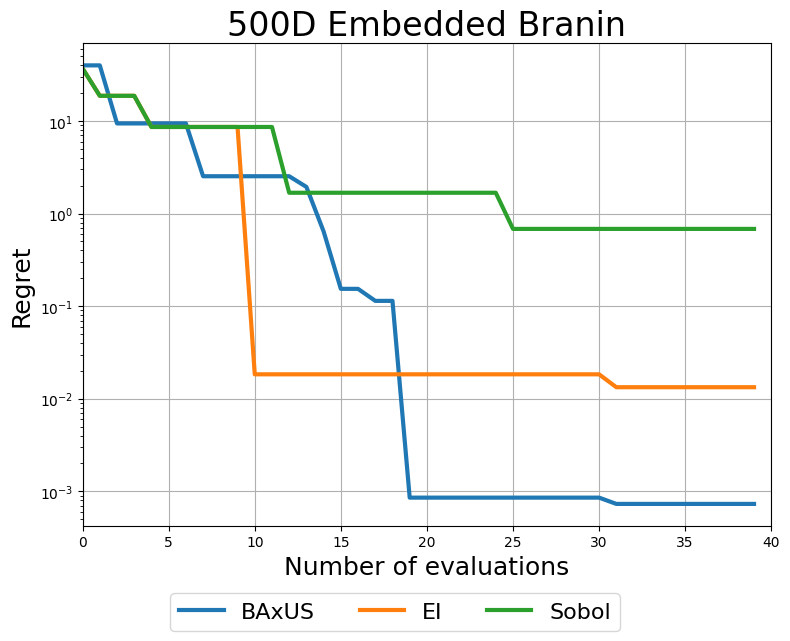

In [19]:
%matplotlib inline

names = ["BAxUS", "EI", "Sobol"]
runs = [Y_baxus, Y_ei, Y_Sobol]
print(Y_ei)
fig, ax = plt.subplots(figsize=(8, 6))
for name, run in zip(names, runs):
    fx =  np.maximum.accumulate(run.cpu())
    plt.plot(-fx + branin.optimal_value, marker="", lw=3)

plt.ylabel("Regret", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title(f"{dim}D Embedded Branin", fontsize=24)
plt.xlim([0, len(Y_baxus)])
plt.yscale("log")

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()

We can see that BAxUS works faster with better performance.